In [5]:
import jax
from jax import numpy as jnp
from jax import grad, jit, vmap
import jax.scipy as jsp
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import haiku as hk
import optax
import random
# import functools

## data

In [6]:
data_dir = 'data/architectural-styles-dataset'
itoc = os.listdir(data_dir)
ctoi = {c:i for i,c in enumerate(itoc)}
n_classes = 5
image_size = 128
files = {c: [f for f in os.listdir(os.path.join(data_dir, c)) if f.endswith('.jpg')] for c in itoc}
rng = jax.random.PRNGKey(0)

In [7]:
def image_file_to_numpy_array(filename):
    x = Image.open(filename)
    w, h = x.size
    if w > h:
        x = x.crop(((w-h)//2, 0, (w+h)//2, h))
    elif h > w:
        x = x.crop((0, (h-w)//2, w, (h+w)//2))
    x = x.resize((image_size, image_size), Image.LANCZOS)
    x = np.array(x) / 255.  # normalize image
    if len(x.shape) == 2:  # ensure 3 channels
        x = np.repeat(x[:, :, np.newaxis], 3, axis=2)
    return x

def load_image_data(rng_key):
    X, Y = [], []
    for c in tqdm(itoc[:n_classes]):
        for f in files[c]:
            X.append(image_file_to_numpy_array(os.path.join(data_dir, c, f)))
            Y.append(ctoi[c])
    shuffle_idx = jax.random.permutation(rng_key, len(X))
    X = jnp.array(X)[shuffle_idx]
    Y = jnp.array(Y)[shuffle_idx]
    return X, Y


def get_batches(X, Y, batch_size=64, rng_key=rng):
    while True:
        shuffle_idx = jax.random.permutation(rng_key, len(X))
        X = X[shuffle_idx]
        Y = Y[shuffle_idx]
        for i in range(0, len(X), batch_size):
            yield X[i:i+batch_size], Y[i:i+batch_size]

In [8]:
rng = jax.random.PRNGKey(0)
X, Y = load_image_data(rng)

100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


In [9]:
rng = jax.random.PRNGKey(0)
train_idx, test_idx = jnp.split(jax.random.permutation(rng, len(X)), [int(.8*len(X))])
train_idx, val_idx = jnp.split(train_idx, [int(.8*len(train_idx))])

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

train_batches = get_batches(X_train, Y_train)
val_batches = get_batches(X_val, Y_val)
test_batches = get_batches(X_test, Y_test)

## haiku

In [35]:

def network_fn(x: jax.Array) -> jax.Array:
    cnn = hk.Sequential([
        hk.Conv2D(32, kernel_shape=3, stride=2, padding='SAME'),
        jax.nn.relu,
        hk.Conv2D(64, kernel_shape=3, stride=2, padding='SAME'),
        jax.nn.relu,
        hk.Conv2D(128, kernel_shape=3, stride=2, padding='SAME'),
    ])
    mlp = hk.Sequential([
        hk.Flatten(),
        hk.Linear(128),
        jax.nn.relu,
        hk.Linear(128),
        jax.nn.relu,
        hk.Linear(n_classes)])
    return mlp(cnn(x))

def loss_fn(params, batch):
    x, y = batch
    logits = forward(params, x)
    return jnp.mean(jsp.special.logsumexp(logits, axis=1) - logits[jnp.arange(len(logits)), y])


@jax.jit
def update(params, opt_state, batch):
    grads = grad(loss_fn)(params, batch)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state


rng = hk.PRNGSequence(jax.random.PRNGKey(42))
init, forward = hk.without_apply_rng(hk.transform(network_fn))
params = init(next(rng), jnp.ones([1, image_size, image_size, 3]))
opt = optax.adam(1e-3)
state = opt.init(params)

In [36]:
steps = 100
losses = [] 
pbar = tqdm(range(steps))
for step in pbar:
    x, y = next(train_batches)
    params, state = update(params, state, (x, y))
    losses.append(loss_fn(params, (x, y)))
    pbar.set_description(f'loss: {losses[-1]:.4f}')


loss: 0.1931: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


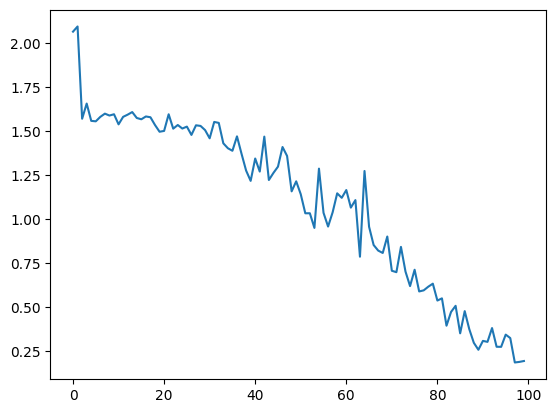

In [37]:
plt.plot(losses)

## visualisation

In [45]:
def plot_small_multiples(params, batches, n=4):
    fig, axes = plt.subplots(n, n, figsize=(n * 3, n * 3), dpi=200)
    fig.tight_layout(h_pad=8)
    for ax in axes.flatten():
            x, y = next(batches)
            y_hat = predict_mlp(params, x)
            ax.imshow(x[0])
            ax.set_title(f"pred: {itoc[np.argmax(y_hat[0])]}\ntrue: {itoc[y[0]]}")
            ax.axis('off')
    plt.show()

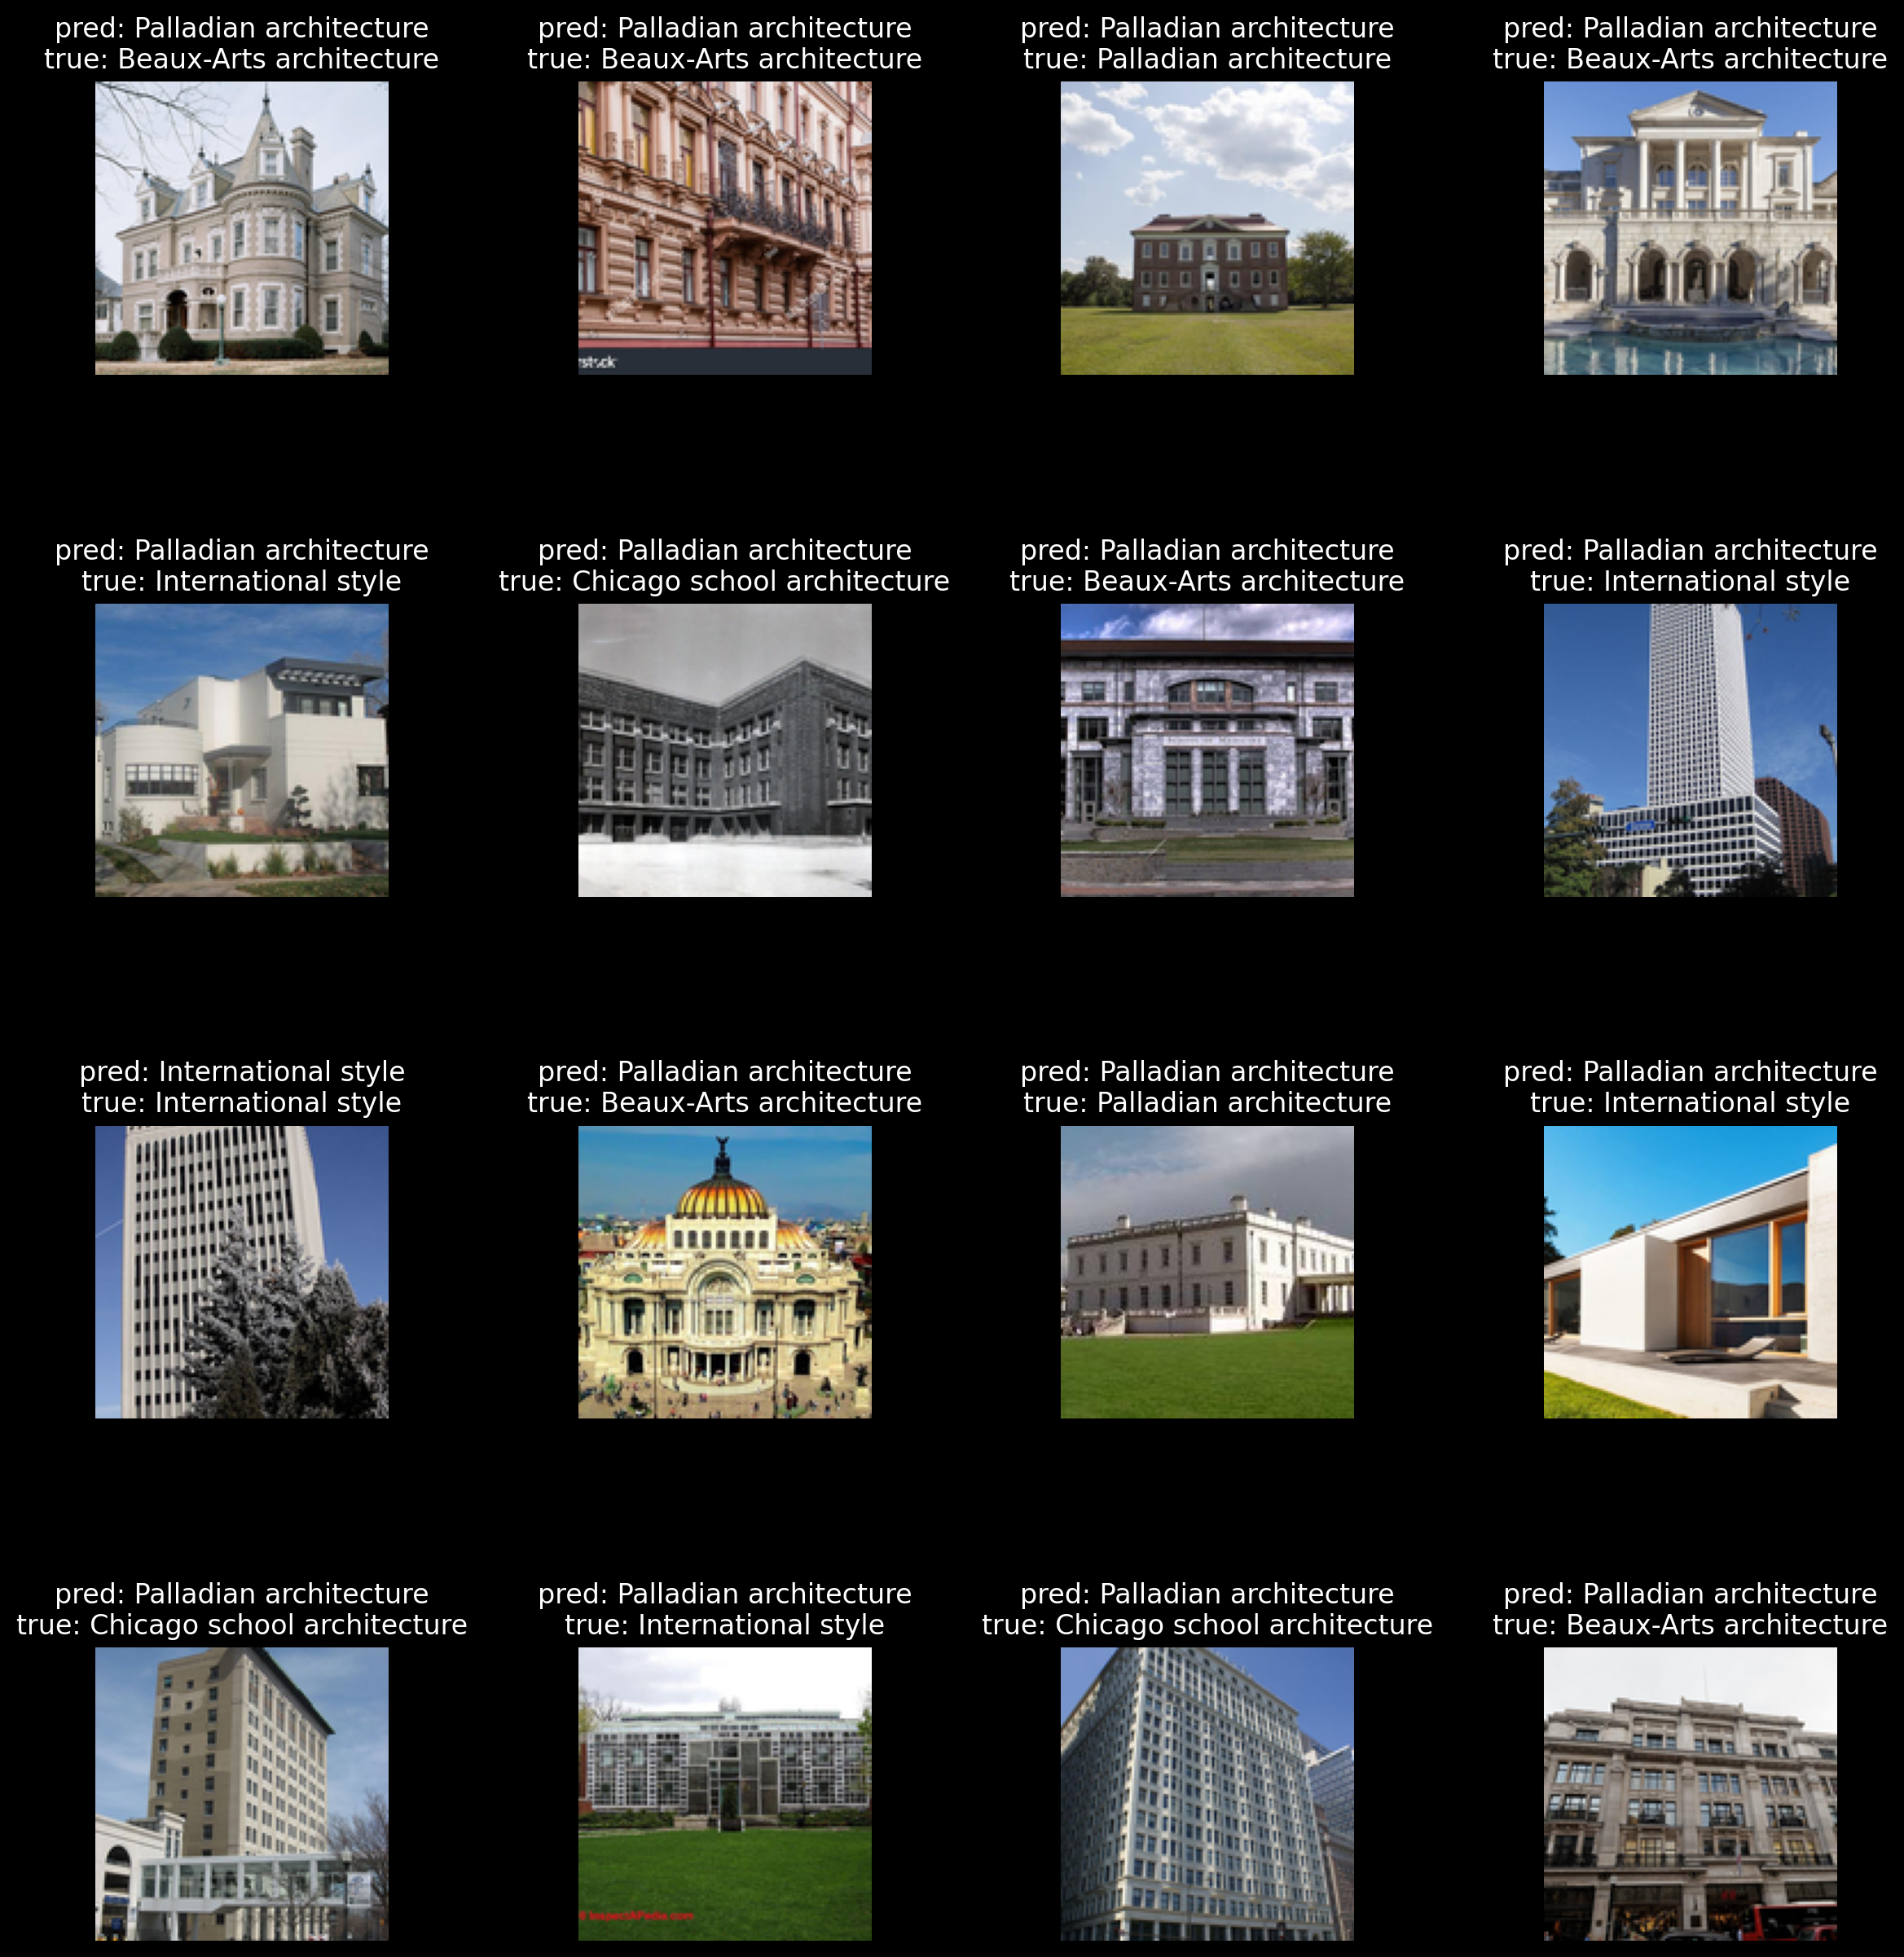

In [46]:
plot_small_multiples(params, test_batches)